<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP1] - Time series with RNN - Preparation of data
<!-- DESC --> Episode 1 : Data analysis and creation of a usable dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Undestand the data
 - cleanup a usable dataset


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read the data
 - Cleanup and build a usable dataset

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys
import math, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP1')

pd.set_option('display.max_rows',200)


**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : SYNOP1
Run time             : Saturday 19 December 2020, 10:43:18
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf
Datasets dir         : /home/pjluc/datasets/fidle
Running mode         : full
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Read the data

In [2]:
data_filename   = 'origine/donnees-synop-essentielles-omm-LYS.csv'
schema_filename = 'origine/schema.json'

### 2.1 - Read columns code

In [3]:
with open(f'{datasets_dir}/SYNOP/{schema_filename}','r') as json_file:
    schema = json.load(json_file)

synop_codes=list( schema['definitions']['donnees-synop-essentielles-omm_records']['properties']['fields']['properties'].keys() )

### 2.2 - Read data

In [4]:
df = pd.read_csv(f'{datasets_dir}/SYNOP/{data_filename}', header=0, sep=';')
pwk.subtitle('Raw data :')
display(df.tail(10))

# ---- Get the columns name as descriptions
synop_desc = list(df.columns)

# ---- Set Codes as columns name
df.columns   = synop_codes
code2desc    = dict(zip(synop_codes, synop_desc))

# ---- Count the na values by columns
columns_na = df.isna().sum().tolist()

# ---- Show all of that
df_desc=pd.DataFrame({'Code':synop_codes, 'Description':synop_desc, 'Na':columns_na})

pwk.subtitle('List of columns :')
display(df_desc.style.set_properties(**{'text-align': 'left'}))

print('Shape is : ', df.shape)

<br>**Raw data :**

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Longitude,Latitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code)
29155,7481,2019-11-16T01:00:00+01:00,100640.0,130.0,1.0,190.0,1.0,272.75,272.75,100.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29156,7481,2019-11-16T19:00:00+01:00,101090.0,90.0,3.0,130.0,3.5,276.95,274.65,85.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29157,7481,2020-02-12T16:00:00+01:00,102460.0,-180.0,6.0,360.0,2.3,283.45,271.75,44.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29158,7481,2020-02-13T04:00:00+01:00,102100.0,-240.0,8.0,150.0,4.9,274.75,271.15,77.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29159,7481,2020-02-14T01:00:00+01:00,102080.0,230.0,1.0,280.0,4.5,283.15,276.15,62.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29160,7481,2020-02-14T07:00:00+01:00,102430.0,210.0,2.0,140.0,3.4,280.15,278.45,89.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29161,7481,2020-02-15T16:00:00+01:00,102190.0,-160.0,6.0,180.0,6.9,290.15,273.75,33.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29162,7481,2020-01-25T22:00:00+01:00,102030.0,20.0,1.0,140.0,4.9,281.45,278.55,82.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29163,7481,2020-01-26T19:00:00+01:00,102010.0,80.0,3.0,170.0,3.7,282.85,279.15,78.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84
29164,7481,2020-02-08T19:00:00+01:00,102540.0,150.0,2.0,190.0,6.2,283.75,277.65,66.0,...,5.077833,45.7265,Colombier-Saugnieu,69299,CC de l'Est Lyonnais (CCEL),246900575,Rhône,69,Auvergne-Rhône-Alpes,84


<br>**List of columns :**

,Code,Description,Na
0,numer_sta,ID OMM station,0
1,date,Date,0
2,pmer,Pression au niveau mer,17
3,tend,Variation de pression en 3 heures,2
4,cod_tend,Type de tendance barométrique,2
5,dd,Direction du vent moyen 10 mn,3
6,ff,Vitesse du vent moyen 10 mn,2
7,t,Température,14
8,td,Point de rosée,17
9,u,Humidité,17


Shape is :  (29165, 81)


## Step 3 - Keep only certain columns

In [5]:
columns_used=['date','pmer','tend','cod_tend','dd','ff','td','u','ww','pres','rafper','per','rr1','rr3','tc']

# ---- Drop unused columns

to_drop = df.columns.difference(columns_used)
df.drop( to_drop, axis=1, inplace=True)

# ---- Show all of that

pwk.subtitle('Our selected columns :')
display(df.head(20))

pwk.subtitle('Few statistics :')
display(df.describe())

# ---- 'per' column is constant, we can drop it

df.drop(['per'],axis=1,inplace=True)


<br>**Our selected columns :**

,date,pmer,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,per,rr1,rr3,tc
0,2015-06-12T17:00:00+02:00,101050.0,-230.0,6.0,140.0,3.6,286.25,50.0,2.0,98330.0,5.1,-10.0,0.0,-0.1,24.2
1,2015-06-05T17:00:00+02:00,101590.0,-220.0,8.0,190.0,3.9,286.95,32.0,3.0,98930.0,9.9,-10.0,0.0,0.0,32.6
2,2015-06-15T11:00:00+02:00,101420.0,90.0,1.0,270.0,1.5,286.85,64.0,3.0,98660.0,4.5,-10.0,0.0,0.0,20.8
3,2015-06-15T14:00:00+02:00,101430.0,20.0,1.0,10.0,2.5,286.45,55.0,1.0,98680.0,5.1,-10.0,0.0,0.0,22.8
4,2015-06-20T05:00:00+02:00,102030.0,0.0,4.0,50.0,0.7,282.95,82.0,2.0,99170.0,2.4,-10.0,0.0,0.0,12.8
5,2015-06-22T05:00:00+02:00,101680.0,-120.0,6.0,180.0,0.7,286.15,80.0,1.0,98870.0,4.7,-10.0,0.0,-0.1,16.5
6,2015-06-23T02:00:00+02:00,101270.0,150.0,2.0,20.0,4.5,282.95,54.0,0.0,98490.0,10.2,-10.0,0.0,0.0,19.3
7,2015-06-25T14:00:00+02:00,102180.0,-40.0,8.0,10.0,2.3,283.25,38.0,1.0,99430.0,7.5,-10.0,0.0,0.0,25.5
8,2015-07-05T20:00:00+02:00,101410.0,50.0,3.0,190.0,8.3,288.05,33.0,3.0,98760.0,13.4,-10.0,0.0,0.0,33.4
9,2015-05-14T17:00:00+02:00,101070.0,-150.0,6.0,20.0,6.2,284.95,60.0,3.0,98300.0,11.1,-10.0,0.0,0.0,19.8


<br>**Few statistics :**

,pmer,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,per,rr1,rr3,tc
count,29148.000000,29163.000000,29163.000000,29162.000000,29163.00000,29148.000000,29148.000000,29164.000000,29165.000000,29156.000000,29157.0,29070.000000,29092.000000,29151.000000
mean,101753.552902,0.255118,4.306930,204.088197,3.39653,280.027865,71.021614,10.106158,98894.598320,6.299005,-10.0,0.092886,0.279008,12.688261
std,798.093804,111.438232,2.716149,115.422508,2.46898,5.857534,18.275755,19.404573,761.586766,3.852478,0.0,0.605673,1.414611,8.146390
min,97960.000000,-750.000000,0.000000,0.000000,0.00000,249.250000,2.000000,0.000000,95170.000000,0.000000,-10.0,-0.100000,-0.100000,-12.100000
25%,101300.000000,-70.000000,2.000000,130.000000,1.50000,275.825000,58.000000,2.000000,98480.000000,3.600000,-10.0,0.000000,0.000000,6.600000
50%,101740.000000,0.000000,3.000000,190.000000,2.90000,280.250000,74.000000,2.000000,98920.000000,5.300000,-10.0,0.000000,0.000000,12.500000
75%,102240.000000,70.000000,7.000000,330.000000,4.60000,284.550000,86.000000,3.000000,99360.000000,8.200000,-10.0,0.000000,0.000000,18.500000
max,104280.000000,810.000000,8.000000,360.000000,18.80000,295.950000,100.000000,97.000000,101210.000000,30.200000,-10.0,19.000000,45.000000,38.900000


## Step 4 - Cleanup session : Let's sort it and cook up some NaN values

In [6]:
# ---- First of all, we have to sort on the date

df.sort_values(['date'],  inplace=True)
df.reset_index(drop=True, inplace=True)

# ---- Before : Lines with NaN

na_rows=df.isna().any(axis=1)
pwk.subtitle('Before :')
display( df[na_rows].head(10) )

# ---- Nice interpolation for plugging holes

df.interpolate(inplace=True)

# ---- After

pwk.subtitle('After :')
display(df[na_rows].head(10))


<br>**Before :**

,date,pmer,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
396,2010-02-19T16:00:00+01:00,99760.0,180.0,3.0,330.0,4.6,275.85,79.0,21.0,96890.0,NaN,0.0,1.0,6.1
434,2010-02-24T10:00:00+01:00,100310.0,60.0,1.0,NaN,NaN,279.25,77.0,2.0,97470.0,NaN,0.2,0.2,9.9
477,2010-03-01T19:00:00+01:00,101400.0,NaN,NaN,340.0,2.6,275.45,61.0,2.0,98520.0,5.7,0.0,NaN,9.4
734,2010-04-03T02:00:00+02:00,101550.0,50.0,0.0,190.0,7.7,277.55,64.0,2.0,98680.0,12.3,NaN,NaN,10.9
1061,2010-05-13T23:00:00+02:00,NaN,60.0,2.0,330.0,4.6,NaN,NaN,2.0,98220.0,7.7,0.0,0.0,9.9
1063,2010-05-14T05:00:00+02:00,NaN,-50.0,5.0,350.0,4.1,NaN,NaN,2.0,98110.0,7.2,0.0,0.0,8.1
1064,2010-05-14T08:00:00+02:00,NaN,0.0,5.0,350.0,4.6,NaN,NaN,2.0,98110.0,6.7,0.0,0.0,8.1
2268,2010-10-11T20:00:00+02:00,NaN,150.0,2.0,10.0,1.0,NaN,NaN,2.0,98060.0,3.1,NaN,NaN,NaN
2269,2010-10-11T23:00:00+02:00,NaN,130.0,3.0,80.0,1.0,NaN,NaN,2.0,98190.0,2.6,NaN,NaN,NaN
2270,2010-10-12T02:00:00+02:00,NaN,70.0,1.0,0.0,0.0,NaN,NaN,2.0,98260.0,1.5,NaN,NaN,NaN


<br>**After :**

,date,pmer,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
396,2010-02-19T16:00:00+01:00,99760.000000,180.0,3.0,330.0,4.60,275.85,79.000000,21.0,96890.0,8.25,0.0,1.0,6.10
434,2010-02-24T10:00:00+01:00,100310.000000,60.0,1.0,170.0,4.15,279.25,77.000000,2.0,97470.0,6.65,0.2,0.2,9.90
477,2010-03-01T19:00:00+01:00,101400.000000,195.0,4.0,340.0,2.60,275.45,61.000000,2.0,98520.0,5.70,0.0,0.5,9.40
734,2010-04-03T02:00:00+02:00,101550.000000,50.0,0.0,190.0,7.70,277.55,64.000000,2.0,98680.0,12.30,0.0,0.0,10.90
1061,2010-05-13T23:00:00+02:00,101020.000000,60.0,2.0,330.0,4.60,281.25,86.500000,2.0,98220.0,7.70,0.0,0.0,9.90
1063,2010-05-14T05:00:00+02:00,101040.000000,-50.0,5.0,350.0,4.10,279.15,80.666667,2.0,98110.0,7.20,0.0,0.0,8.10
1064,2010-05-14T08:00:00+02:00,101040.000000,0.0,5.0,350.0,4.60,279.35,79.333333,2.0,98110.0,6.70,0.0,0.0,8.10
2268,2010-10-11T20:00:00+02:00,100786.666667,150.0,2.0,10.0,1.00,284.75,83.333333,2.0,98060.0,3.10,0.0,0.0,14.45
2269,2010-10-11T23:00:00+02:00,100863.333333,130.0,3.0,80.0,1.00,284.45,84.666667,2.0,98190.0,2.60,0.0,0.0,13.90
2270,2010-10-12T02:00:00+02:00,100940.000000,70.0,1.0,0.0,0.00,284.15,86.000000,2.0,98260.0,1.50,0.0,0.0,13.35


## Step 5 - Final dataset
### 5.1 - Summarize it

In [7]:
# ---- Count the na values by columns
dataset_na    = df.isna().sum().tolist()
dataset_cols  = df.columns.tolist()
dataset_desc  = [ code2desc[c] for c in dataset_cols ]

# ---- Show all of that
df_desc=pd.DataFrame({'Columns':dataset_cols, 'Description':dataset_desc, 'Na':dataset_na})
pwk.subtitle('Dataset columns :')
display(df_desc.style.set_properties(**{'text-align': 'left'}))

pwk.subtitle('Have a look :')
display(df.tail(20))
print('Shape is : ', df.shape)

<br>**Dataset columns :**

,Columns,Description,Na
0,date,Date,0
1,pmer,Pression au niveau mer,0
2,tend,Variation de pression en 3 heures,0
3,cod_tend,Type de tendance barométrique,0
4,dd,Direction du vent moyen 10 mn,0
5,ff,Vitesse du vent moyen 10 mn,0
6,td,Point de rosée,0
7,u,Humidité,0
8,ww,Temps présent,0
9,pres,Pression station,0


<br>**Have a look :**

,date,pmer,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
29145,2020-02-24T13:00:00+01:00,102380.0,-220.0,8.0,120.0,1.6,281.15,59.0,0.0,99540.0,3.7,0.0,0.0,16.0
29146,2020-02-24T16:00:00+01:00,101990.0,-350.0,6.0,110.0,1.6,281.55,50.0,3.0,99190.0,3.3,0.0,0.0,19.1
29147,2020-02-24T19:00:00+01:00,101800.0,-220.0,6.0,150.0,2.9,280.05,55.0,3.0,98970.0,4.1,0.0,0.0,15.9
29148,2020-02-24T22:00:00+01:00,101740.0,-80.0,6.0,170.0,1.8,280.35,67.0,2.0,98890.0,4.3,0.0,0.0,13.2
29149,2020-02-25T01:00:00+01:00,101640.0,-150.0,8.0,170.0,2.5,278.85,83.0,2.0,98740.0,4.7,0.0,0.0,8.4
29150,2020-02-25T04:00:00+01:00,101450.0,-200.0,6.0,150.0,3.7,277.75,87.0,2.0,98540.0,4.8,0.0,0.0,6.6
29151,2020-02-25T07:00:00+01:00,101530.0,60.0,3.0,30.0,4.0,276.95,92.0,3.0,98600.0,6.1,0.0,0.0,5.0
29152,2020-02-25T10:00:00+01:00,101490.0,-20.0,8.0,200.0,1.8,277.55,87.0,3.0,98580.0,5.5,0.0,0.0,6.4
29153,2020-02-25T13:00:00+01:00,101330.0,-140.0,8.0,150.0,3.8,278.95,85.0,21.0,98440.0,7.1,0.6,2.0,8.2
29154,2020-02-25T16:00:00+01:00,100990.0,-290.0,6.0,140.0,4.4,279.55,69.0,3.0,98150.0,7.2,0.0,0.0,11.9


Shape is :  (29165, 14)


### 5.2 - Have a look (1 month)

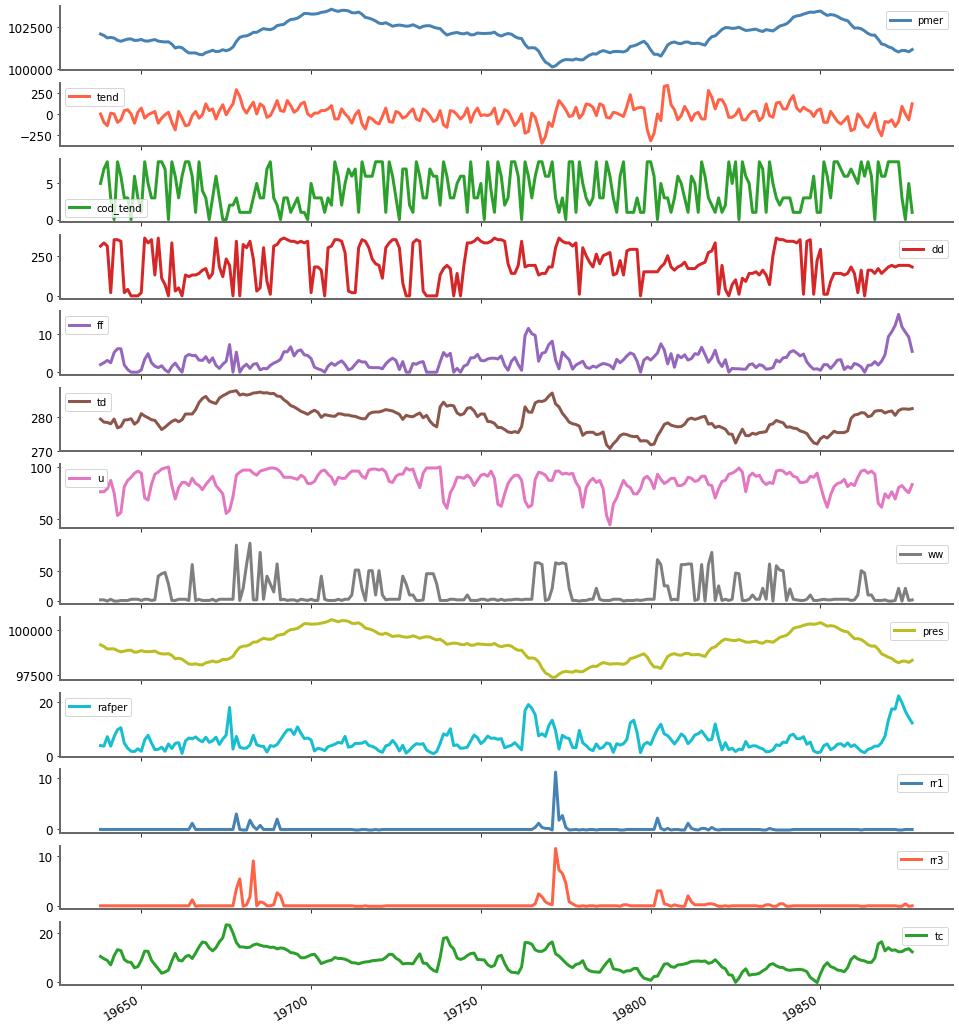

In [8]:
i=random.randint(0,len(df)-240)
df.iloc[i:i+240].plot(subplots=True, fontsize=12, figsize=(16,20))
pwk.save_fig('01-one-month')
plt.show()

## Step 3 - Save it

In [9]:
dataset_name = 'synop-LYS.csv'
dataset_desc = 'synop.json'
output_dir   = './data'

# ---- Save it
#

pwk.mkdir(output_dir)

filedata = f'{output_dir}/{dataset_name}'
filedesc = f'{output_dir}/{dataset_desc}'

df.to_csv(filedata, sep=';', index=False)
size=os.path.getsize(filedata)/(1024*1024)
print(f'Dataset saved. ({size:0.1f} Mo)')

with open(filedesc, 'w', encoding='utf-8') as f:
    json.dump(code2desc, f, indent=4)
print('Synop description saved.')
    

Dataset saved. (3.0 Mo)
Synop description saved.


In [10]:
pwk.end()

End time is : Saturday 19 December 2020, 10:43:22
Duration is : 00:00:04 776ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>